# Проект по А/B-тестированию

Цели исследования:
- Оценить корректность проведения теста:

1) Проверить пересечение тестовой аудитории с конкурирующим тестом;

2) Проверить совпадение теста и маркетинговых событий, другие проблемы временных границ теста;

- Провести исследовательский анализ данных:

1) Исследовать конверсию в воронке на разных этапах;

2) Исследовать есть ли в выборках одни и те же пользователи;

3) Исследовать как число событий распределено по дням;

4) Исследовать распределение клиентов по регионам;


- Провести оценку результатов A/B-тестирования: 

1) Проверьте статистическую разницу долей z-критерием;

- Проанализировать результаты теста

## Шаг №1. Загрузка данных и подготовка их к анализу

In [1]:
#импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
from functools import reduce
from scipy import stats as st
import warnings
warnings.filterwarnings("ignore")

In [2]:
#откроем таблицу marketing_events и выведем её на экран
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [3]:
# Просмотрим основную информацию по данной таблице
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
name         14 non-null object
regions      14 non-null object
start_dt     14 non-null object
finish_dt    14 non-null object
dtypes: object(4)
memory usage: 576.0+ bytes


В таблице нет пропущенных значений, но столбцы с датой имеют тип данных object, их нужно изменить

In [4]:
# Приведем столбцы start_dt и finish_dt к типу данных дата
marketing_events['start_dt'] = marketing_events['start_dt'].map(
    lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
)

marketing_events['finish_dt'] = marketing_events['finish_dt'].map(
    lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
)

In [5]:
#откроем таблицу new_users и выведем её на экран
new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
new_users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
# Просмотрим основную информацию по данной таблице
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
user_id       61733 non-null object
first_date    61733 non-null object
region        61733 non-null object
device        61733 non-null object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
# Проверим таблицу на дубликаты
print('В таблице new_users', new_users.duplicated().sum(), 'дубликатов')

В таблице new_users 0 дубликатов


В нашей таблице нет пропусков, нет дубликатов, но столбец с датой имеет тип данных object

In [8]:
# Приведем столбец first_date к типу данных дата
new_users['first_date'] = new_users['first_date'].map(
    lambda x: dt.datetime.strptime(x,'%Y-%m-%d')
)

In [9]:
#откроем таблицу events и выведем её на экран
events = pd.read_csv('/datasets/final_ab_events.csv')
events.head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [10]:
# Просмотрим основную информацию по данной таблице
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
user_id       440317 non-null object
event_dt      440317 non-null object
event_name    440317 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [11]:
# Проверим таблицу на дубликаты
print('В таблице events', events.duplicated().sum(), 'дубликатов')

В таблице events 0 дубликатов


In [12]:
# Посмотрим соответствует ли количество заполненных строк в столбце details количеству событий event_name
events[events.event_name == 'purchase'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
user_id       62740 non-null object
event_dt      62740 non-null object
event_name    62740 non-null object
details       62740 non-null float64
dtypes: float64(1), object(3)
memory usage: 2.4+ MB


В таблице нет дубликатов, но есть пропущенных значения в столбце details, в нём содежится сумма покупки в долларах, для типа событий покупки. Т.к. не все события имеют данный тип, то и пропущенные значения также есть в данной колонке.

Колонка с датой имеет неверный тип данных, изменим его на дату.

In [13]:
# Приведем столбец event_dt к типу данных дата
events['event_dt'] = events['event_dt'].map(
    lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
)

In [14]:
#откроем таблицу participants и выведем её на экран
participants = pd.read_csv('/datasets/final_ab_participants.csv')
participants.head(5)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [15]:
# Просмотрим основную информацию по данной таблице
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
user_id    18268 non-null object
group      18268 non-null object
ab_test    18268 non-null object
dtypes: object(3)
memory usage: 428.3+ KB


In [16]:
# Проверим таблицу на дубликаты
print('В таблице participants', participants.duplicated().sum(), 'дубликатов')

В таблице participants 0 дубликатов


В таблице нет дубликатов, пропущенных значений и все ячейки соответствуют типам данных.

### Вывод

Таблица marketing_events - это календарь маркетинговых событий на 2020 год;
Таблица имеет 14 строк и 4 столбца:

- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

В таблице new_users пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года.
Таблица имеет 61733 строки и 4 столбца:

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

В таблице events у нас все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;
Таблица имеет 440317 строки и 4 столбца:

- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — в этом поле хранится стоимость покупки в долларах.

Таблтца participants - это таблица участников тестов.
Таблица имеет 18268 строк и 3 столбца:

- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

В таблицах не было дубликатов, во всех таблицах я изменила типы данных у столбцов с датами, т.к. они имели тип object.
Пропуски есть только в таблице events в столбце с суммой покупки, но т.к. не все события из данной таблицы имеют тип покупка, то и есть пропущенные в данном столбце.

## Шаг №2. Исследовательский анализ данных

### Период данных, кол-во событий и пользователей в логах.

Всего событий в логе 440317.

Всего пользователей в логе 58703.

В среднем на пользователя приходится 6 событий.


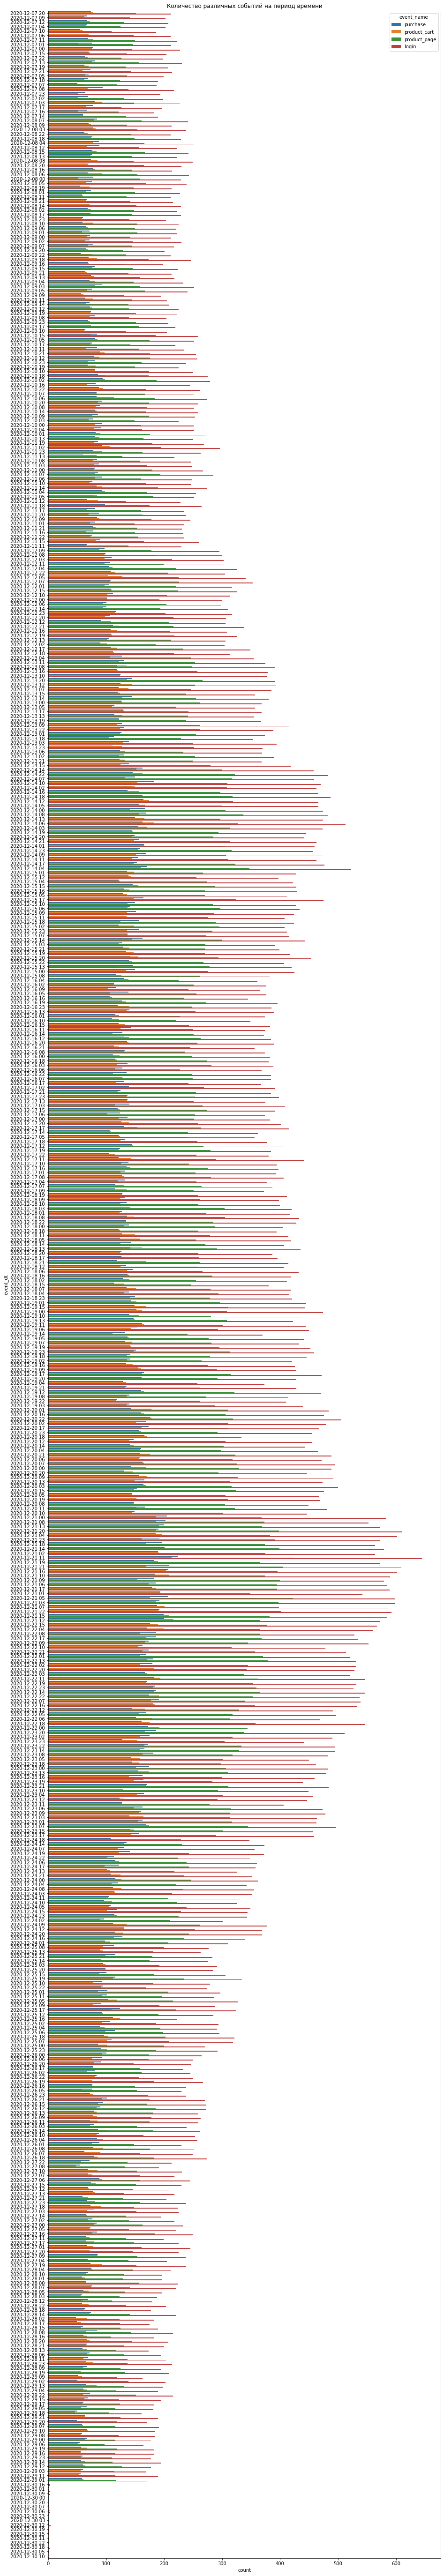

In [17]:
print('Всего событий в логе {}.'.format(len(events['user_id'])))
print('')
print('Всего пользователей в логе {}.'.format(events['user_id'].nunique()))
print('')
print('В среднем на пользователя приходится {} событий.'
      .format(int(events.groupby('user_id').agg({'event_dt': 'count'}).median())))

plt.figure(figsize=(15, 100))
ax = sns.countplot(y=events['event_dt'].dt.strftime('%Y-%m-%d %H'), hue='event_name', data=events)
ax.set_title('Количество различных событий на период времени')
plt.show()

#### Вывод

Всего событий в логе 440317.

Всего пользователей в логе 58703.

В среднем на пользователя приходится 6 событий.

В период после 29 декабря 01 часа у нас очень мало данных.

Также в период с 25 декабря по 3 января у нас проходит промо акция, что может очень сильно исказить данные теста.

### Изучение воронки событий

Нам нужно провести изучение событий и воронки продаж на основе теста recommender_system_test

In [18]:
# Сначала проверим, есть ли участники теста попавшие в обе группы
common_clients = np.intersect1d(participants[participants.ab_test == 'recommender_system_test'].query('group == "A"')['user_id'].unique(), participants[participants.ab_test == 'recommender_system_test'].query('group == "B"')['user_id'].unique())
print('Участников, попавших в обе группы по тесту recommender_system_test ', len(common_clients), 'человек')

Участников, попавших в обе группы по тесту recommender_system_test  0 человек


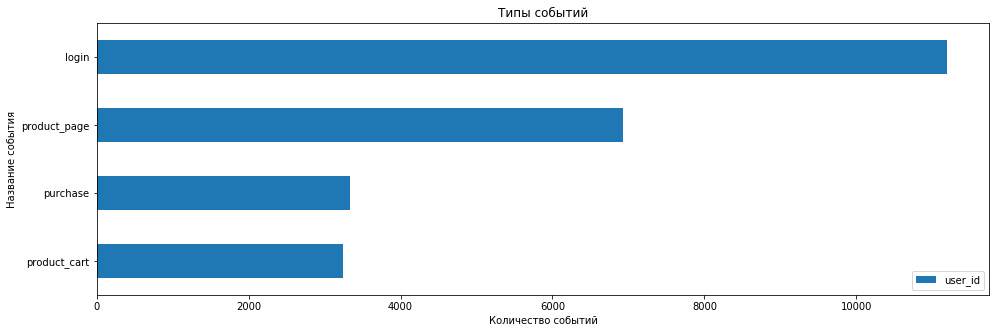

In [19]:
# Объединим таблицу participants по тесту recommender_system_test и events
data = participants[participants.ab_test == 'recommender_system_test'].merge(events, on='user_id', how='left')

# Построим график по типу событий и отсортируем его по убыванию
data.groupby('event_name').agg({'user_id': 'count'}).sort_values('user_id', ascending = True).plot(figsize=(16, 5), kind='barh')

# Добавим подпись к таблице, вынесем легенду за график, и развернем подписи к оси x
plt.title('Типы событий')
plt.xlabel('Количество событий')
plt.ylabel('Название события');

In [20]:
# Посмотрим какие типы событий в нашей таблице
data['event_name'].value_counts()

login           11190
product_page     6930
purchase         3331
product_cart     3247
Name: event_name, dtype: int64

#### Вывод

Всего у нас 4 вида событий в таблице:
 - login - вошёл в приложении - его совершили 11 190 раз
 - product_page - открыл страницу продукта - его совершили 6 930 раза
 - purchase - совершил покупку - его совершили 3 331 раза
 - product_cart - открыл корзину - его совершили 3 247 раз
 
 
Скорее всего клиент может, не просматривая корзину, перейти на этап оформления покупки и это отображается как этап "покупка".

### Распределение клиентов по регионам

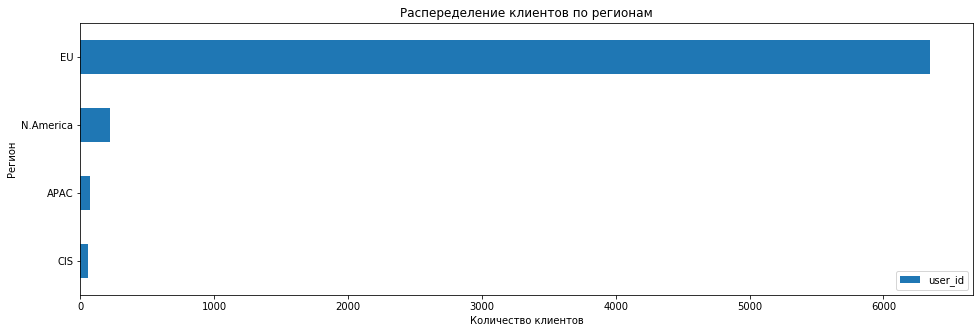

In [21]:
# Создадим таблицу с данными по региону клиентов, объединив две таблицы data и new_users
data_region = data.merge(new_users, on ='user_id', how='left')
# Посмотрим на распределение наших клиентов по регионам
data_region.groupby('region').agg({'user_id': 'nunique'}).sort_values('user_id', ascending = True).plot(figsize=(16, 5), kind='barh')

# Добавим подпись к таблице
plt.title('Распеределение клиентов по регионам')
plt.xlabel('Количество клиентов')
plt.ylabel('Регион');

In [22]:
data_region_tabl = data_region.pivot_table(index = 'region', values='user_id', columns=['group'], aggfunc=['nunique']).reset_index()
data_region_tabl.columns = ['region', 'A', 'B']
data_region_tabl['all'] = new_users[new_users.region == 'EU']['user_id'].nunique()
data_region_tabl['share'] = ((data_region_tabl['B'] + data_region_tabl['A']) / data_region_tabl['all'] * 100).round(1)
data_region_tabl.sort_values('A', ascending = False)

,region,A,B,all,share
2,EU,3634,2717,46270,13.7
3,N.America,128,95,46270,0.5
0,APAC,37,35,46270,0.2
1,CIS,25,30,46270,0.1


#### Вывод

Нам нужно было выяснить, что новых клиентов из региона EU у нас как минимум 15%.

В итого клиентов из региона UE из новой группы клиентов 13,7%.

### Сколько пользователей совершали то или иное событие.

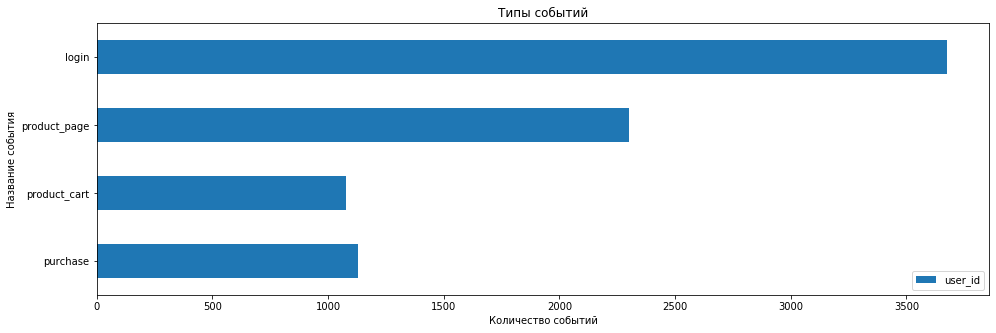

In [23]:
data.groupby('event_name').agg({'user_id': 'nunique'}).reindex(['purchase', 'product_cart', 'product_page', 'login']).plot(figsize=(16, 5), kind='barh')
# Добавим подпись к таблице, вынесем легенду за график, и развернем подписи к оси x
plt.title('Типы событий')
plt.xlabel('Количество событий')
plt.ylabel('Название события');

In [24]:
# Создадим новую таблицу и несколько столбцов в ней, чтобы вычислить долю пользоватлей
data_1=data.pivot_table(index='event_name', values='user_id', aggfunc=['nunique']).reset_index()
data_1.columns = ['name', '123', 'id']
data_1 = data_1[['name', 'id']]
data_1['all_id'] = data['user_id'].nunique()
data_1['share'] = (data_1['id'] / data_1['all_id'] * 100).round(1)
# Изменим таблицу в порядок login, product_page, product_cart, purchase
data_1 = data_1.reindex([0, 2, 1, 3])

У нас всего 6701 клиентов, но часть из них и вовсе не производило никаких действий, попробуем узнать сколько

In [25]:
# Сделаем отборку по столбцу event_name с пропущенными значениями и посмотрим количество уникальных id,
# у которых не было ни одного действия
print(data[data['event_name'].isnull()]['user_id'].nunique(), 'клиентов не произвели ни одного действия')

3026 клиентов не произвели ни одного действия


In [ ]:
# Построим воронку продаж
fig = go.Figure(go.Funnel(
    y = (data_1['name']),
    x = (data_1['id'])))

fig.show()

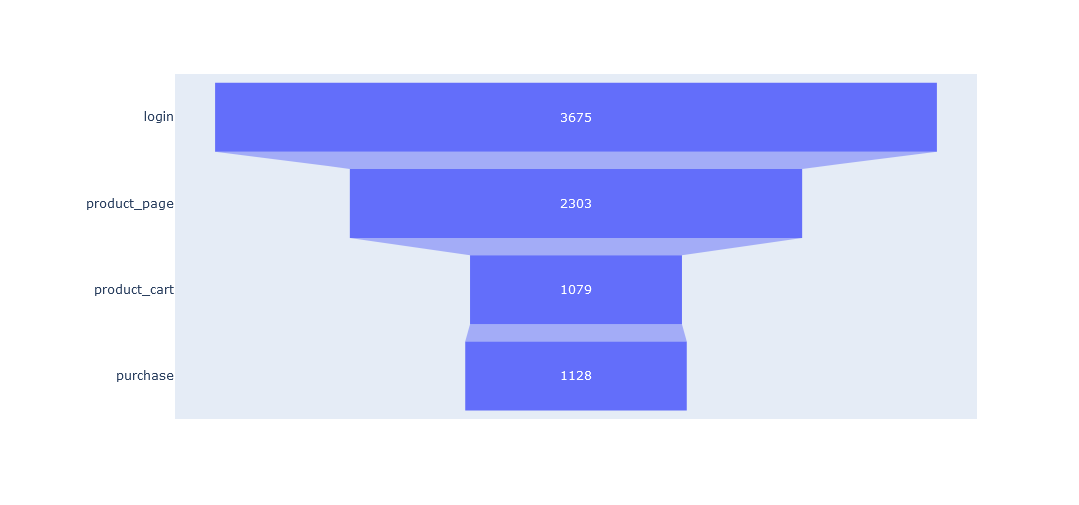

#### Вывод

Событие "открытие главного экран" (login) совершили 3675 клиентов - это 54,8% от всех пользователей

Событие "открытие экрана продукта" (product_page) совершили 2303 клиента - это 34,4% от всех пользователей

Событие "покупка" (purchase) совершили 1128 клиентов - это 16,8% от всех пользователей

Событие "открытие корзины" (product_cart) совершили 1079 клиентов - это 16,1% от всех пользователей

Также у нас есть  3026 клиентов, которые не произвели ни одного действия.

У нас ожидаемое количество участников теста: 6000. Данный порог мы приодолели, но 3026 не произволи ни одно действия, тогда у нас остается всего 3675 активных участников теста.

### Пересечение аудиторий тестов

In [26]:
# Посмотрим сколько у нас тестов
participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [27]:
# Проверим сколько пользователей попало в обе группы в тесте interface_eu_test
common_clients = np.intersect1d(participants[participants.ab_test == 'interface_eu_test'].query('group == "A"')['user_id'].unique(), participants[participants.ab_test == 'interface_eu_test'].query('group == "B"')['user_id'].unique())
print(len(common_clients), 'пользоватлей попало в обе группы в тесте interface_eu_test')

0 пользоватлей попало в обе группы в тесте interface_eu_test


In [28]:
common_clients = np.intersect1d(participants[participants.ab_test == 'interface_eu_test'].query('group == "A"')['user_id'].unique(), participants[participants.ab_test == 'recommender_system_test'].query('group == "A"')['user_id'].unique())
print(len(common_clients), 'общих пользователей теста interface_eu_test группы А и теста recommender_system_test группы А')

482 общих пользователей теста interface_eu_test группы А и теста recommender_system_test группы А


In [29]:
common_clients = np.intersect1d(participants[participants.ab_test == 'interface_eu_test'].query('group == "B"')['user_id'].unique(), participants[participants.ab_test == 'recommender_system_test'].query('group == "A"')['user_id'].unique())
print(len(common_clients), 'общих пользователей теста interface_eu_test группы В и теста recommender_system_test группы А')

439 общих пользователей теста interface_eu_test группы В и теста recommender_system_test группы А


In [30]:
common_clients = np.intersect1d(participants[participants.ab_test == 'interface_eu_test'].query('group == "A"')['user_id'].unique(), participants[participants.ab_test == 'recommender_system_test'].query('group == "B"')['user_id'].unique())
print(len(common_clients), 'общих пользователей теста interface_eu_test группы А и теста recommender_system_test группы В')

337 общих пользователей теста interface_eu_test группы А и теста recommender_system_test группы В


In [31]:
common_clients = np.intersect1d(participants[participants.ab_test == 'interface_eu_test'].query('group == "B"')['user_id'].unique(), participants[participants.ab_test == 'recommender_system_test'].query('group == "B"')['user_id'].unique())
print(len(common_clients), 'общих пользователей теста interface_eu_test группы В и теста recommender_system_test группы В')

344 общих пользователей теста interface_eu_test группы В и теста recommender_system_test группы В


In [32]:
common_clients = np.intersect1d(participants.query('ab_test == "interface_eu_test"')['user_id'].unique(), participants.query('ab_test == "recommender_system_test"')['user_id'].unique())
print('Всего', len(common_clients), 'пользователей попало в оба теста')

Всего 1602 пользователей попало в оба теста


In [33]:
print(len(participants[participants.ab_test == 'interface_eu_test'].query('group == "A"')), 'пользователей теста interface_eu_test в группе А')

5831 пользователей теста interface_eu_test в группе А


In [34]:
print(len(participants[participants.ab_test == 'interface_eu_test'].query('group == "B"')), 'пользователей теста interface_eu_test в группе B')

5736 пользователей теста interface_eu_test в группе B


In [35]:
print(len(participants[participants.ab_test == 'recommender_system_test'].query('group == "A"')), 'пользователей теста recommender_system_test в группе А')

3824 пользователей теста recommender_system_test в группе А


In [36]:
print(len(participants[participants.ab_test == 'recommender_system_test'].query('group == "B"')), 'пользователей теста recommender_system_test в группе B')

2877 пользователей теста recommender_system_test в группе B


In [37]:
# Создадим новый дата фрейм с данными пересекающихся пользователей
common_clients_data = pd.DataFrame({'': ['interface eu test group A', 'interface eu test group B'], 
                                  'recommender system test group A': [482, 439],
                                  'recommender system test group B': [337, 344]})
common_clients_data

,,recommender system test group A,recommender system test group B
0,interface eu test group A,482,337
1,interface eu test group B,439,344


In [38]:
# Создадим новый дата фрейм с данными пересекающихся пользователей
common_clients_share = pd.DataFrame({'': ['interface eu test group A', 'interface eu test group B', 'recommender system test group A', 'recommender system test group B'], 
                                  'share': [(482 + 337) / 5831, (439 + 344) / 5736, (482 + 439) / 3824, (337 + 344) / 2877]})
common_clients_share

,,share
0,interface eu test group A,0.140456
1,interface eu test group B,0.136506
2,recommender system test group A,0.240847
3,recommender system test group B,0.236705


#### Вывод

Всего у нас 1602 пользователя которые попали в оба теста.
- 482 пользователя попало в тест recommender system test группы А и тест interface eu test group группы А
- 439 пользователей попало в тест recommender system test группы А и тест interface eu test group группы В
- 337 пользователей попало в тест recommender system test группы В и тест interface eu test group группы А
- 344 пользователей попало в тест  recommender system test группы В и тест interface eu test group группы В

Итого:
- В тесте interface eu test группы А есть 14,05% пользователей, которые пересекаются с другим тестом
- В тесте interface eu test группы В есть 13,65% пользователей, которые пересекаются с другим тестом
- В тесте recommender system test группы А есть 24,08% пользователей, которые пересекаются с другим тестом
- В тесте recommender system test групп В есть 23,67% пользователей, которые пересекаются с другим тестом

Это равномерное распределение пользователей.

## Шаг №3. Изучение результатов эксперемента

In [39]:
# Создадим сводную таблицу по группам пользователей и событиям, которые они совершали, по тесту interface_eu_test
df = data.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
# Скинем индексы
df = df.reset_index()
# Переименуем колонки
df.columns = ['name', 'A', 'B']
# Изменим таблицу в порядок login, product_page, product_cart, purchase
df = df.reindex([0, 2, 1, 3])
# Также создадим ключи, чтобы по номеру группы выводилось количество клиентов в этой группе
group_id = {'A': data[data.group == 'A']['user_id'].nunique(),
           'B': data[data.group == 'B']['user_id'].nunique()}

Сформулируем нулевую и альтернативную гипотезы:

 - Нулевая гипотеза: Доли в группах одинаковые
 - Альтернативная гипотеза : Доли в группах разные
 
Наши гипотезы будем проверять с уровнем значимости статистического теста = 0.10

In [40]:
# Создадим функцию для сравнение долей в группах
def difference(group_1, group_2, alpha):
    for i in df.index:
        alpha = alpha
        # сколько людей выполнило действие относительно общего количества в первой группе
        p1 = df[group_1][i] / group_id[group_1]
        # сколько людей выполнило действие относительно общего количества во второй группе
        p2 = df[group_2][i] / group_id[group_2]
        # сколько людей выполнило действие относительно общего количества
        p3 = ((df[group_1][i] + df[group_2][i]) / (group_id[group_1]+group_id[group_2]))
        # разница пропорций
        difference = p1 - p2
        # статистика в ст.отклонениях стандартного нормального распределения
        value = difference / np.sqrt(p3 * (1-p3) * (1/group_id[group_1] + 1/ group_id[group_2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(value))) * 2
        print('Для события {} p-значение: {}'.format(df['name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: доли в группах", group_1, 'и', group_2, 'разные')
        else:
            print("Не получилось отвергнуть нулевую гипотезу: доли в группах", group_1, 'и', group_2, 'одинаковые')
        print('')
        
# И добавим также в функцию построение воронки для наглядности   
    fig = go.Figure()
    for i, group in enumerate([group_1, group_2]):
        fig.add_trace(go.Funnel(
            name = str(group),
            y = df['name'],
            x = df[group]))

    fig.show()

In [41]:
difference('A', 'B', 0.10)

Для события login p-значение: 0.0
Отвергаем нулевую гипотезу: доли в группах A и B разные

Для события product_page p-значение: 0.0
Отвергаем нулевую гипотезу: доли в группах A и B разные

Для события product_cart p-значение: 0.0
Отвергаем нулевую гипотезу: доли в группах A и B разные

Для события purchase p-значение: 0.0
Отвергаем нулевую гипотезу: доли в группах A и B разные



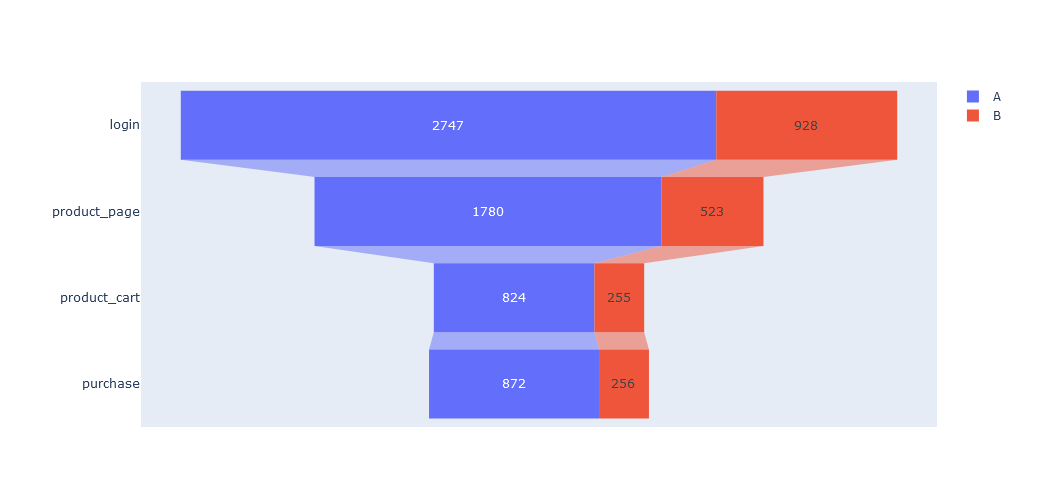

### Вывод

Есть значимая разница между группой A и экспериментальной группой B.

## Вывод

В четырех базовых таблицах у нас не было дублированных срок, и пропусков (кроме таблицы events в столбце details, где была указана сумма покупки, но т.к. не все события являются покупками, то и в данных строках есть пропуски).

Везде был неправильный тип данных для дат, я их поменяла на нужный.

Дата проведения нашего теста пересекается с новогодней промо акцией (с 25 декабря по 3 января), что может очень сильно исказить данные теста.

Всего в логе 440317 событий, 58703 пользователей, в среднем на пользователя приходится 6 событий.

В таблице есть 4 типа событий

 - login - открытие главного экран - его совершили 3675 клиентов(это 54,8% от всех пользователей) 11 190 раз
 - product_page - открытие экрана продукта - его совершили 2303 клиента (это 34,4% от всех клиентов)  6 930 раза
 - product_cart - открытие корзины - его совершили 1079 клиентав (это 16,1% от всех клиентов) 3 247 раза
 - purchase - покупка - его совершили 1128 клиентов (это 16,8% от всех клиентов) 3 331 раз

Также у нас есть  3026 клиентов, которые не произвели ни одного действия.

У нас ожидаемое количество участников теста: 6000. Данный порог мы приодолели, но 3026 не произволи ни одно действия, тогда у нас остается всего 3675 активных участников теста.

Также у нас есть 1602 клиента, которые принимают участия в обоих тестах:

- В тесте interface eu test группы А есть 14,05% пользователей, которые пересекаются с другим тестом
- В тесте interface eu test группы В есть 13,65% пользователей, которые пересекаются с другим тестом
- В тесте recommender system test группы А есть 24,08% пользователей, которые пересекаются с другим тестом
- В тесте recommender system test групп В есть 23,67% пользователей, которые пересекаются с другим тестом

Это равномерное распределение пользователей.

Нам нужно было выяснить, что новых клиентов (из группы В) из региона EU у нас как минимум 15%. В итого клиентов из региона UE из новой группы клиентов 13.7%.

Я провела 4 проверки статистических гипотез с уровнем значимости  0,10 между контрольными группой и группой с улучшенной рекомендательной системой, где результат, что есть значимая разница между данными группами.

Но наш эксперемент проведён некорректно:
 - Время проведения теста пересекается с промо акцией.
 - Вместо 15% новых клиентов из региона EU, у нас всего 13,7%.
 - Вместо 6000 участников, у нас всего 3675 активных участников.

Потому нельзя делать какие либо выводы из данного эксперемента, нельзя сделать вывод какая платёжная воронка лучше.

Нужно продлить время эксперемента (для набора необходимого количества участников) и удалить некорректные временные данные (пересечение с промо акцией / ями).